# Simulation Zürich Bahnhofstrasse: Basis-Modell & Erweiterung

Diese Simulation modelliert den Pendlerverkehr an der **Zürcher Bahnhofstrasse** (HB -> Bürkliplatz).
Das Ziel ist es, das Verhalten von Passagieren (Wartezeit, Zufriedenheit) und den Einfluss von Störungen (Baustellen) auf den Modal Split (Bus vs. Tram) zu untersuchen.

### Struktur des Notebooks
1.  **Konfiguration**: Parameter der Simulation (Zeit, Ort, Skala).
2.  **Agenten**: Definition von Fahrgästen (`PassengerAgent`) und Fahrzeugen (`VehicleAgent`).
3.  **Modell**: Das `ZurichTransportModel`, welches die Umgebung und den Ablauf steuert.
4.  **Szenario A (Basis)**: Normaler Verkehrsfluss ohne Störungen.
5.  **Szenario B (Erweiterung)**: Simulation mit Baustelle am Rennweg, was zu Staus und Umsteigeverhalten führt.


In [1]:
import mesa
import random
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# --- KONFIGURATION ---
# Ort: Zürich, Bahnhofstrasse (HB -> Bürkliplatz)
# Skala: 1 Zelle = ca. 10 Meter
# Länge: ca. 1.5 km = 150 Zellen
# Zeit: 1 Tick = 20 Sekunden
TICK_DURATION_SECONDS = 20 
GRID_LENGTH = 150 

# Haltestellen-Positionen (auf dem Gitter 0-150)
STOPS = {
    "Zürich HB": 5,
    "Rennweg": 50,
    "Paradeplatz": 100,
    "Bürkliplatz": 145
}


Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/opt/anaconda3/envs/mss-ngs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Definition der Agenten

Wir unterscheiden zwei Typen von Agenten:

### PassengerAgent (Fahrgast)
* Hat eine Präferenz (Bus oder Tram) und eine Startposition.
* **Wartezeit**: Wird in Realzeit getrackt.
* **Zufriedenheit**: Sinkt mit der Wartezeit. Tram-Fahrer sind etwas geduldiger als Bus-Fahrer.
* **Kipp-Punkt (Switching Logic)**: Wenn ein Bus-Fahrgast länger als **5 Minuten** wartet, verliert er die Geduld und wechselt auf das Tram (Erweiterung, die im Simulationsverlauf relevant wird).

### VehicleAgent (Fahrzeug)
* **Tram**: Fährt auf Spur 1, konstante Geschwindigkeit (4 Zellen/Tick ~ 20km/h). **Emissionen: 0g** (Gilt als lokal emissionsfrei).
* **Bus**: Fährt auf Spur 0, etwas langsamer (3 Zellen/Tick). Emittiert CO2 basierend auf dem Fahrzustand.
    * *Normalfahrt:* 5g CO2 pro Tick (moderner Hybridbus).
    * *Stau/Leerlauf:* **10g CO2 pro Tick** (Erhöhter Ausstoss durch Stop-and-Go).
* **Baustelle**: Wenn aktiv, kann der Bus zwischen Rennweg und Paradeplatz stecken bleiben. Dies führt nicht nur zu Verspätungen, sondern treibt durch den **Leerlauf** die CO2-Bilanz massiv in die Höhe.

In [2]:
# --- 1. Agenten Klassen ---

class PassengerAgent(mesa.Agent):
    """Ein Fahrgast in Zürich."""
    def __init__(self, unique_id, model, transport_type_preference, origin_pos):
        super().__init__(model) 
        self.unique_id = unique_id
        self.transport_type = transport_type_preference 
        self.origin_pos = origin_pos
        
        # Tracking in Realzeit
        self.waiting_start_time = model.current_time
        self.waiting_minutes = 0.0
        
        self.satisfaction = 100 
        self.arrived = False
        self.has_switched = False 

    def step(self):
        if not self.arrived:
            # Wartezeit berechnen (Realzeit)
            current_wait = self.model.current_time - self.waiting_start_time
            self.waiting_minutes = current_wait.total_seconds() / 60.0
            
            # Zufriedenheit sinkt (Tram-Fahrer sind entspannter als Bus-Fahrer)
            decay_factor = 0.5 if self.transport_type == "Tram" else 0.8
            # Alle 20 Sekunden sinkt die Zufriedenheit
            self.satisfaction -= (decay_factor * 0.5) 
            if self.satisfaction < 0: self.satisfaction = 0

            # --- SWITCHING LOGIC (Kipp-Punkt) ---
            # Wenn man länger als 5 Minuten wartet, wechselt man
            if self.transport_type == "Bus" and self.waiting_minutes > 5.0:
                self.switch_to_tram()

    def switch_to_tram(self):
        """Passagier läuft rüber zu den Tramgleisen."""
        self.transport_type = "Tram"
        self.has_switched = True
        self.satisfaction -= 15 # Ärger über das Wechseln (Einmalige Kosten)
        
        # Visueller Wechsel auf Spur 1 (Tramgleis)
        x, y = self.pos
        if y == 0: 
            self.model.grid.move_agent(self, (x, 1))

class VehicleAgent(mesa.Agent):
    """ZVV Bus oder Tram mit CO2-Emissionen."""
    def __init__(self, unique_id, model, v_type):
        super().__init__(model)
        self.unique_id = unique_id
        self.v_type = v_type 
        self.co2_emitted = 0.0 # Kumulierte Emissionen in Gramm
        
        if v_type == "Tram":
            self.speed = 4 
        else:
            self.speed = 3 

    def step(self):
        x, y = self.pos
        move_distance = self.speed
        
        # --- CO2 BERECHNUNG ---
        # Annahme: 1 Tick = 20 Sek. 
        # Bus im Leerlauf/Stau: 10g pro Tick
        # Bus fahrend: 5g pro Tick (moderne Hybridbusse)
        # Tram: 0g (Lokal emissionsfrei / Ökostrom)
        
        current_step_emission = 0
        
        # --- Baustellen-Logik ---
        is_stuck = False
        if self.v_type == "Bus" and self.model.construction_active:
            if 50 <= x <= 90: # Baustelle Rennweg
                if random.random() < 0.8: 
                    move_distance = 0 
                    is_stuck = True
                else:
                    move_distance = 1 

        # Emissionen addieren
        if self.v_type == "Bus":
            if is_stuck or move_distance < self.speed:
                current_step_emission = 10.0 # Hoher Ausstoss im Stau (Stop & Go)
            else:
                current_step_emission = 5.0 # Normaler Ausstoss
        
        self.co2_emitted += current_step_emission

        # Bewegung
        new_x = (x + move_distance) % self.model.grid.width 
        self.model.grid.move_agent(self, (new_x, y))
        
        # Passagiere einsammeln
        pickup_range = range(x, x + move_distance + 1)
        for check_x in pickup_range:
            real_check_x = check_x % self.model.grid.width
            cell_mates = self.model.grid.get_cell_list_contents([(real_check_x, y)])
            for mate in cell_mates:
                if isinstance(mate, PassengerAgent) and not mate.arrived:
                    if mate.transport_type == self.v_type:
                        mate.arrived = True


## 2. Das Modell

Das `ZurichTransportModel` initialisiert die Umgebung (MultiGrid) und verwaltet alle Agenten.
**Neu**: Es akzeptiert nun den Parameter `num_buses`, um Szenarien mit unterschiedlicher Flottengrösse (z.B. Taktverdichtung) zu simulieren.

Es sammelt zudem erweiterte Daten für die Auswertung:
- **Durchschnittliche Zufriedenheit** der Passagiere.
- **Warteschlangen**: Anzahl wartender Passagiere pro Verkehrsmittel.
- **Wechsler-Quote**: Anzahl der Passagiere, die entnervt vom Bus zum Tram wechseln.
- **Ökologischer Fussabdruck**: Die kumulierten **CO2-Emissionen** aller Fahrzeuge (in kg), um den Umwelt-Impact von Staus und Flottenerweiterungen zu messen.

In [5]:
# --- 2. Modell & Hilfsfunktionen ---

def compute_avg_satisfaction(model):
    passengers = [a for a in model.agents if isinstance(a, PassengerAgent)]
    if not passengers: return 0
    return sum([a.satisfaction for a in passengers]) / len(passengers)

def count_waiting(model, v_type):
    return sum([1 for a in model.agents 
                if isinstance(a, PassengerAgent) 
                and a.transport_type == v_type 
                and not a.arrived])

def count_switchers(model):
    """Zählt, wie viele Leute bisher umgestiegen sind."""
    return sum([1 for a in model.agents 
                if isinstance(a, PassengerAgent) and a.has_switched])

# --- KORRIGIERTES MODELL (Tram_Wait wieder eingefügt) ---

class ZurichTransportModel(mesa.Model):
    """Erweitertes Modell: Variable Flottengrösse & CO2-Tracking."""
    
    def __init__(self, num_passengers, construction_active=True, num_buses=3):
        super().__init__()
        self.construction_active = construction_active
        self.current_time = datetime(2025, 6, 1, 7, 30, 0)
        
        self.grid = mesa.space.MultiGrid(GRID_LENGTH, 2, torus=True)

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Time": lambda m: m.current_time,
                "Avg_Satisfaction": compute_avg_satisfaction,
                "Bus_Wait": lambda m: count_waiting(m, "Bus"),
                # HIER WAR DER FEHLER: Diese Zeile hatte gefehlt
                "Tram_Wait": lambda m: count_waiting(m, "Tram"), 
                "Total_Switchers": count_switchers,
                "Total_CO2": compute_total_co2 
            }
        )

        # 1. Fahrzeuge erstellen (Variable Anzahl Busse!)
        # Standard: 3 Trams
        for i in range(3):
            self.grid.place_agent(VehicleAgent(f"Tram_{i}", self, "Tram"), (i * 40, 1))

        # Variabel: Busse (Taktverdichtung = mehr Busse)
        # Wir verteilen sie gleichmässig auf der Strecke (150 Zellen)
        spacing = 150 // num_buses
        for i in range(num_buses):
            self.grid.place_agent(VehicleAgent(f"Bus_{i}", self, "Bus"), (i * spacing, 0)) 

        # 2. Passagiere erstellen
        stop_locations = list(STOPS.values())
        for i in range(num_passengers):
            p_type = "Bus" if random.random() < 0.6 else "Tram"
            start_pos = random.choice(stop_locations)
            a = PassengerAgent(i + 100, self, p_type, start_pos)
            y_pos = 0 if p_type == "Bus" else 1
            self.grid.place_agent(a, (start_pos, y_pos))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("step")
        self.current_time += timedelta(seconds=TICK_DURATION_SECONDS)

# Hilfsfunktion für CO2
def compute_total_co2(model):
    vehicles = [a for a in model.agents if isinstance(a, VehicleAgent)]
    return sum([v.co2_emitted for v in vehicles]) / 1000.0 # In kg umrechnen


## 3. Szenario A: Normalbetrieb (Basis)

In diesem Szenario simulieren wir einen normalen Morgenverkehr **ohne** Baustellen.
- `construction_active = False`
- Wir erwarten keine massiven Staus und wenig bis gar keine Wechsel vom Bus zum Tram (da die Wartezeiten im Rahmen bleiben sollten).


Starte Szenario A: Normalbetrieb (ohne Baustelle)...


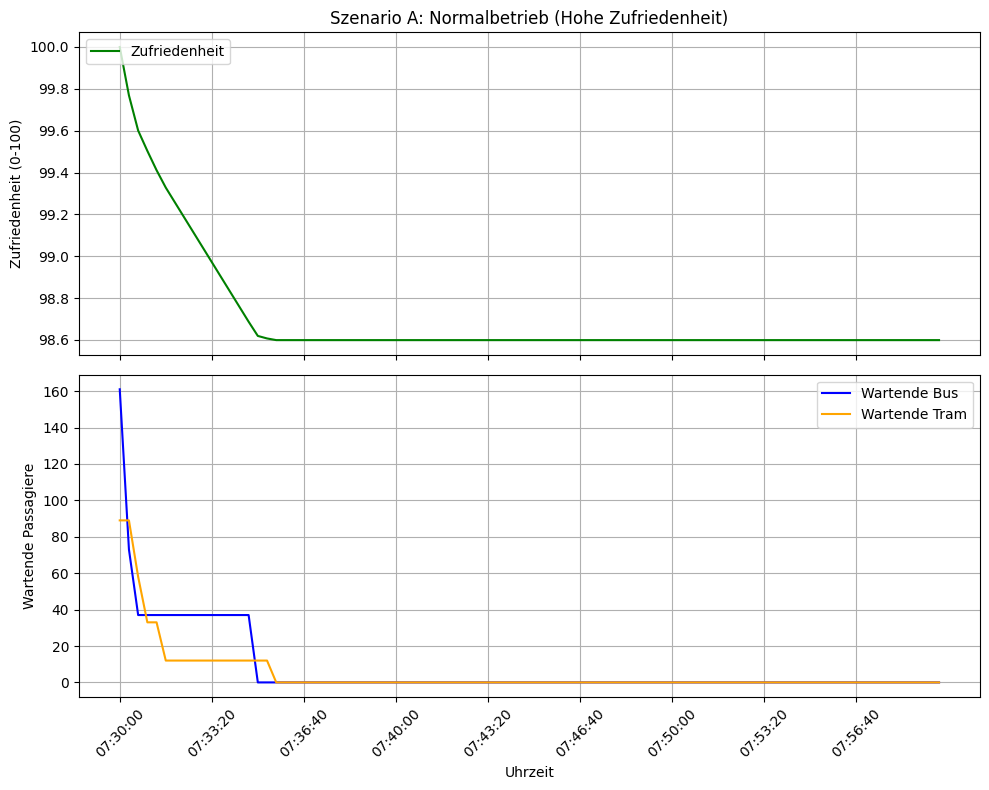

Anzahl Umsteiger in Szenario A: 0


In [6]:
# --- Simulation A: Keine Baustelle ---
print("Starte Szenario A: Normalbetrieb (ohne Baustelle)...")

# Modell initialisieren
model_a = ZurichTransportModel(num_passengers=250, construction_active=False)

# 30 Minuten simulieren (90 Ticks)
for i in range(90): 
    model_a.step()

# Ergebnisse holen
results_a = model_a.datacollector.get_model_vars_dataframe()

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
time_labels = results_a["Time"].dt.strftime('%H:%M:%S')

# Zufriedenheit
ax1.plot(results_a["Time"], results_a["Avg_Satisfaction"], label="Zufriedenheit", color="green")
ax1.set_ylabel("Zufriedenheit (0-100)")
ax1.set_title("Szenario A: Normalbetrieb (Hohe Zufriedenheit)")
ax1.legend(loc="upper left")
ax1.grid(True)

# Warteschlangen
ax2.plot(results_a["Time"], results_a["Bus_Wait"], label="Wartende Bus", color="blue")
ax2.plot(results_a["Time"], results_a["Tram_Wait"], label="Wartende Tram", color="orange")
ax2.set_ylabel("Wartende Passagiere")
ax2.set_xlabel("Uhrzeit")
ax2.legend()
ax2.grid(True)

# X-Achse Formatierung
ax2.set_xticks(results_a["Time"][::10])
ax2.set_xticklabels(time_labels[::10], rotation=45)

plt.tight_layout()
plt.show()

print(f"Anzahl Umsteiger in Szenario A: {results_a['Total_Switchers'].iloc[-1]}")


## 4. Szenario B: Störfall Baustelle (Erweiterung)

Nun aktivieren wir die **Baustelle am Rennweg**.
- `construction_active = True`
- Busse bleiben mit hoher Wahrscheinlichkeit stecken.
- Die Wartezeiten für Bus-Passagiere steigen an.
- Sobald die Wartezeit 5 Minuten überschreitet, greift die `switch_to_tram` Logik: Passagiere wechseln genervt das Verkehrsmittel.


Starte Szenario B: Baustelle am Rennweg...


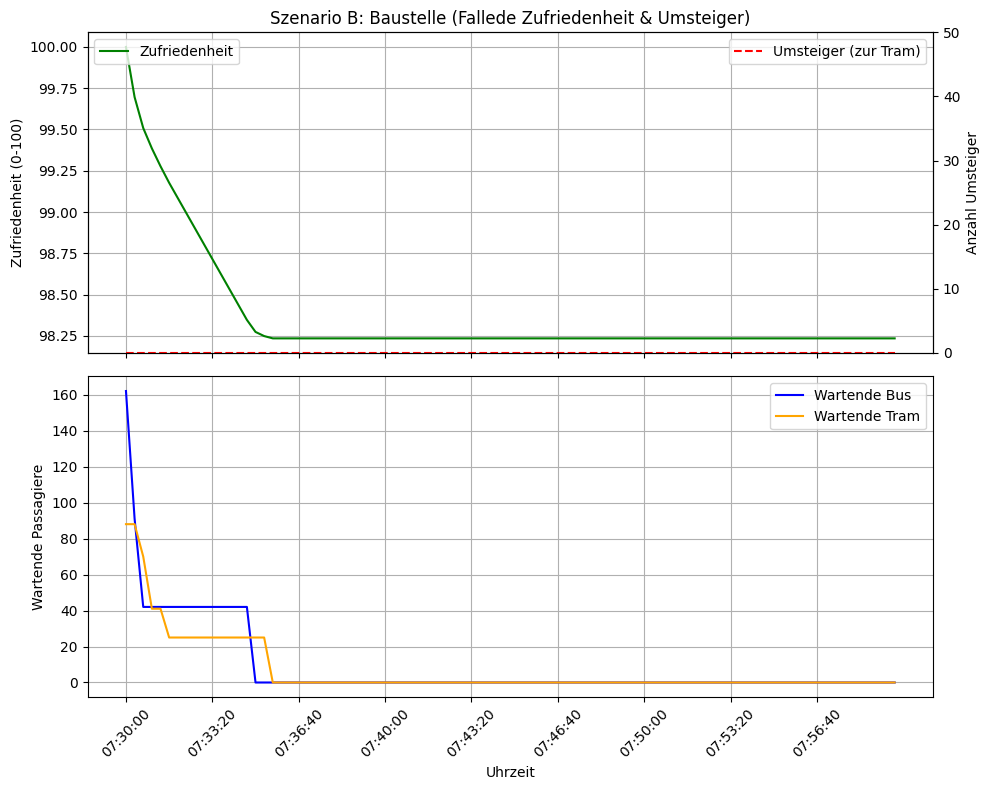

Anzahl Umsteiger in Szenario B: 0


In [7]:
# --- Simulation B: Mit Baustelle ---
print("Starte Szenario B: Baustelle am Rennweg...")

# Modell initialisieren
model_b = ZurichTransportModel(num_passengers=250, construction_active=True)

# 30 Minuten simulieren
for i in range(90): 
    model_b.step()

results_b = model_b.datacollector.get_model_vars_dataframe()

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
time_labels = results_b["Time"].dt.strftime('%H:%M:%S')

# Zufriedenheit & Wechsler
ax1.plot(results_b["Time"], results_b["Avg_Satisfaction"], label="Zufriedenheit", color="green")
ax1.set_ylabel("Zufriedenheit (0-100)")
ax1.legend(loc="upper left")
ax1.grid(True)

ax1b = ax1.twinx()
ax1b.plot(results_b["Time"], results_b["Total_Switchers"], label="Umsteiger (zur Tram)", color="red", linestyle="--")
ax1b.set_ylabel("Anzahl Umsteiger")
ax1b.legend(loc="upper right")
ax1b.set_ylim(0, 50) # Fixe Skala für Vergleichbarkeit
ax1.set_title("Szenario B: Baustelle (Fallede Zufriedenheit & Umsteiger)")

# Warteschlangen
ax2.plot(results_b["Time"], results_b["Bus_Wait"], label="Wartende Bus", color="blue")
ax2.plot(results_b["Time"], results_b["Tram_Wait"], label="Wartende Tram", color="orange")
ax2.set_ylabel("Wartende Passagiere")
ax2.set_xlabel("Uhrzeit")
ax2.legend()
ax2.grid(True)

ax2.set_xticks(results_b["Time"][::10])
ax2.set_xticklabels(time_labels[::10], rotation=45)

plt.tight_layout()
plt.show()

print(f"Anzahl Umsteiger in Szenario B: {results_b['Total_Switchers'].iloc[-1]}")


## 5. Szenario C: Die Intervention (Taktverdichtung)

Hier untersuchen wir die **Schleife B1 (Betriebsanpassung)** aus der Systemkarte.
Die Forschungsfrage lautet: *"Welchen Einfluss hat eine Taktverdichtung während der Stosszeiten auf CO2 und Zufriedenheit?"*

**Setup:**
* `construction_active = True` (Die Baustelle ist immer noch da!)
* `num_buses = 6` (Statt 3 Busse setzen wir 6 ein -> Taktverdichtung).

**Hypothese (System Thinking):**
* Mehr Busse könnten die Wartezeiten senken (Zufriedenheit steigt).
* ABER: Mehr Busse stehen auch öfter im Stau an der Baustelle.
* **Zielkonflikt**: Die CO2-Emissionen könnten drastisch steigen.

Starte Szenario C: Baustelle MIT Taktverdichtung (6 Busse)...


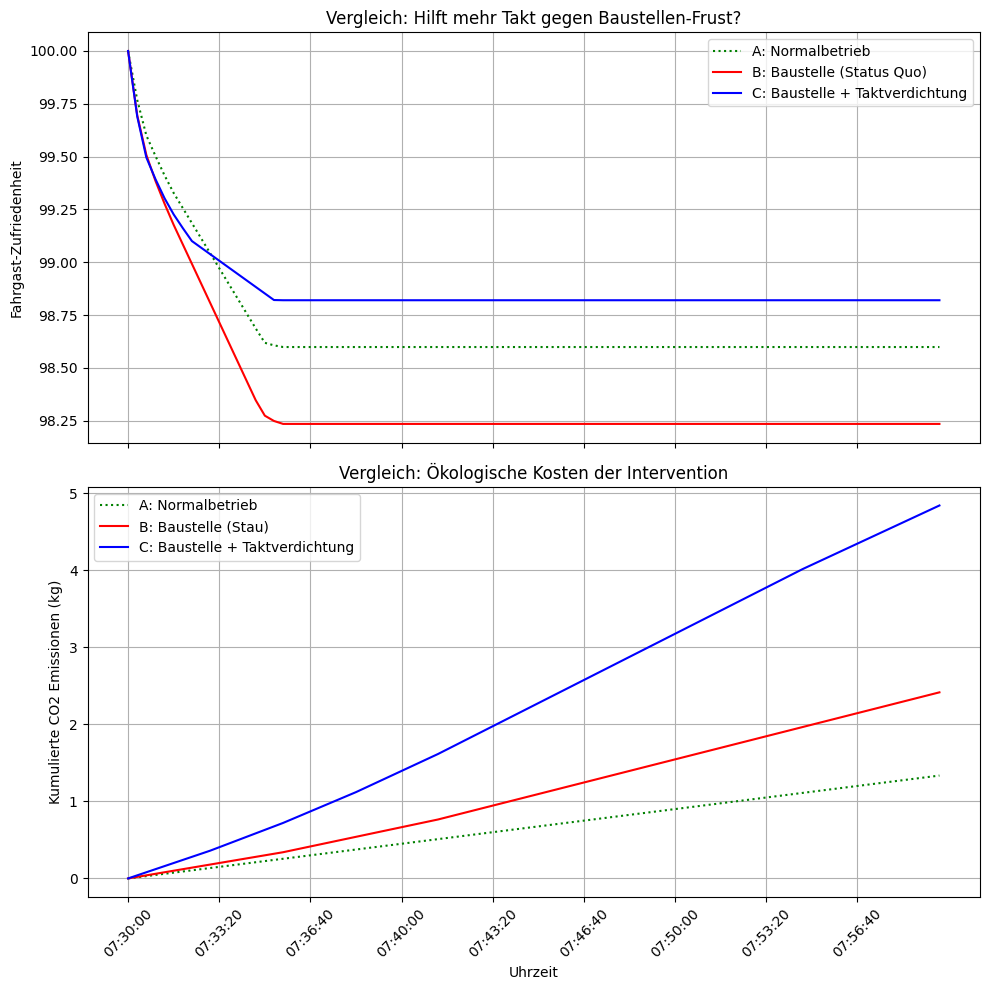

--- Fazit der Simulation ---
Szenario B (Baustelle): End-Zufriedenheit = 98.2, CO2 = 2.42 kg
Szenario C (Verdichtung): End-Zufriedenheit = 98.8, CO2 = 4.84 kg
--> Die Taktverdichtung verbesserte die Zufriedenheit um 0.6%, erhöhte aber die CO2-Emissionen um 100.4%.


In [8]:
print("Starte Szenario C: Baustelle MIT Taktverdichtung (6 Busse)...")

# Modell C: Baustelle AN, aber doppelt so viele Busse (6 statt 3)
model_c = ZurichTransportModel(num_passengers=250, construction_active=True, num_buses=6)

for i in range(90): 
    model_c.step()

results_c = model_c.datacollector.get_model_vars_dataframe()

# --- Vergleich aller Szenarien (A, B, C) ---
# Wir plotten Zufriedenheit und CO2 im Vergleich

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

# 1. Zufriedenheit im Vergleich
ax1.plot(results_a["Time"], results_a["Avg_Satisfaction"], label="A: Normalbetrieb", color="green", linestyle=":")
ax1.plot(results_b["Time"], results_b["Avg_Satisfaction"], label="B: Baustelle (Status Quo)", color="red")
ax1.plot(results_c["Time"], results_c["Avg_Satisfaction"], label="C: Baustelle + Taktverdichtung", color="blue")
ax1.set_ylabel("Fahrgast-Zufriedenheit")
ax1.set_title("Vergleich: Hilft mehr Takt gegen Baustellen-Frust?")
ax1.legend()
ax1.grid(True)

# 2. CO2 Emissionen im Vergleich
ax2.plot(results_a["Time"], results_a["Total_CO2"], label="A: Normalbetrieb", color="green", linestyle=":")
ax2.plot(results_b["Time"], results_b["Total_CO2"], label="B: Baustelle (Stau)", color="red")
ax2.plot(results_c["Time"], results_c["Total_CO2"], label="C: Baustelle + Taktverdichtung", color="blue")
ax2.set_ylabel("Kumulierte CO2 Emissionen (kg)")
ax2.set_xlabel("Uhrzeit")
ax2.set_title("Vergleich: Ökologische Kosten der Intervention")
ax2.legend()
ax2.grid(True)

# X-Achse
time_labels = results_a["Time"].dt.strftime('%H:%M:%S')
ax2.set_xticks(results_a["Time"][::10])
ax2.set_xticklabels(time_labels[::10], rotation=45)

plt.tight_layout()
plt.show()

# Quantitative Auswertung für den Bericht
print("--- Fazit der Simulation ---")
sat_b = results_b['Avg_Satisfaction'].iloc[-1]
sat_c = results_c['Avg_Satisfaction'].iloc[-1]
co2_b = results_b['Total_CO2'].iloc[-1]
co2_c = results_c['Total_CO2'].iloc[-1]

print(f"Szenario B (Baustelle): End-Zufriedenheit = {sat_b:.1f}, CO2 = {co2_b:.2f} kg")
print(f"Szenario C (Verdichtung): End-Zufriedenheit = {sat_c:.1f}, CO2 = {co2_c:.2f} kg")

delta_sat = ((sat_c - sat_b) / sat_b) * 100
delta_co2 = ((co2_c - co2_b) / co2_b) * 100

print(f"--> Die Taktverdichtung verbesserte die Zufriedenheit um {delta_sat:.1f}%, erhöhte aber die CO2-Emissionen um {delta_co2:.1f}%.")